In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-04 11:59:24.645812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dev = qml.device('default.mixed', wires=2)

In [3]:
def real():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)

In [4]:
print(qml.draw(real)())

0: ──Rot(0.00,1.57,0.52)─┤  


In [5]:
p = 0
def generator(w,**kwargs):
    qml.RZ(w[0], wires=0)
    qml.RX(w[1], wires=0)
    qml.RZ(w[2], wires=0)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=0)
    #qml.BitFlip(p, wires=0)
    #qml.BitFlip(p, wires=1)

In [6]:
print(qml.draw(generator)([ 0,0,0]))

0: ──RZ(0.00)──RX(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)─┤  


In [7]:
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=1)
    qml.RY(w[7], wires=1)
    qml.RZ(w[8], wires=1)
    #qml.BitFlip(p, wires=0)
    #qml.BitFlip(p, wires=2)

In [8]:
print(qml.draw(discriminator)([ 0,1,2,3,4,5,6,7,8]))

0: ──H─────────RX(0.00)──RY(2.00)──RZ(4.00)─╭●───────────────────────────────┤  
1: ──RX(1.00)──RY(3.00)──RZ(5.00)───────────╰X──RX(6.00)──RY(7.00)──RZ(8.00)─┤  


In [9]:
@qml.qnode(dev, interface='tf')
def real_disc_circuit(disc_weights):
    real()
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev,interface='tf')
def gen_disc_circuit(gen_weights,disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(1))

In [10]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(disc_weights)
    #convert to probability
    prob_real_true = (true_disc_output+1)/2
    return prob_real_true

In [11]:
def prob_fake_true(gen_weights,disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights,disc_weights)
    #convert to probability
    prob_fake_true = (fake_disc_output+1)/2
    return prob_fake_true

In [12]:
def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights,disc_weights)-prob_real_true(disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = -prob_fake_true(gen_weights,disc_weights)
    return cost

In [ ]:
@qml.qnode(dev, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()
@qml.qnode(dev, interface="tf")
def circuit_rs():
    real()
    return qml.state()

In [13]:
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   #np.random.normal(scale=eps, size=(9,))
    
init_gen_weights = np.array([0]*3)
init_disc_weights = np.random.normal(size=(9,))
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

2023-06-04 11:59:33.758813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]
epochs = 10
for i in range(epochs):
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step_d.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step_g.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[0])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[1])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

Step 0: cost = -0.33288640164087135
Step 5: cost = -0.4767750160196183
Step 10: cost = -0.4974220063548259
Step 15: cost = -0.49972221638279246
Step 20: cost = -0.49997016267511074
Step 25: cost = -0.49999679613432674
Step 30: cost = -0.4999996559865887
Step 35: cost = -0.4999999630618366
Step 40: cost = -0.4999999960337952
Step 45: cost = -0.4999999995741319
Step 0: cost = -0.32836822874107985
Step 5: cost = -0.7868745958406784
Step 10: cost = -0.9702438363990527
Step 15: cost = -0.9966949550772561
Step 20: cost = -0.999643800946564
Step 25: cost = -0.999961738098576
Step 30: cost = -0.999995891480941
Step 35: cost = -0.9999995588469754
Step 40: cost = -0.9999999526294043
Step 45: cost = -0.9999999949114924
Step 0: cost = 0.17164299979893627
Step 5: cost = -0.2868226459549067
Step 10: cost = -0.47020811708024196
Step 15: cost = -0.49666650390170064
Step 20: cost = -0.49961659531903335
Step 25: cost = -0.4999347103303281
Step 30: cost = -0.4999688874416151
Step 35: cost = -0.4999725578

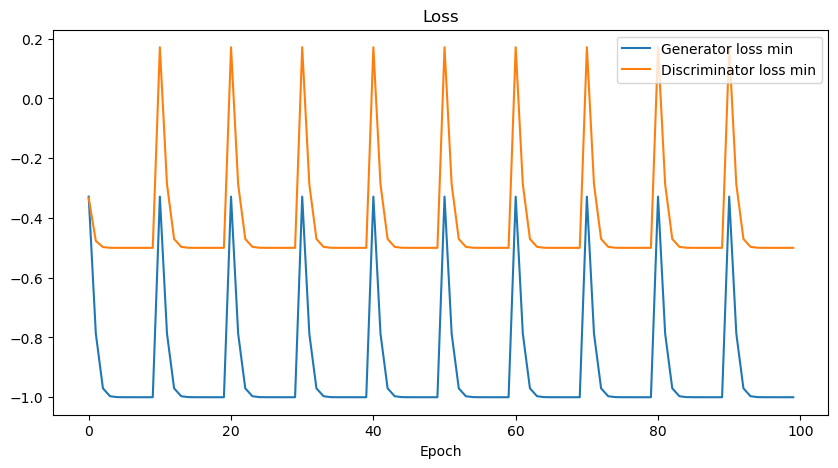

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

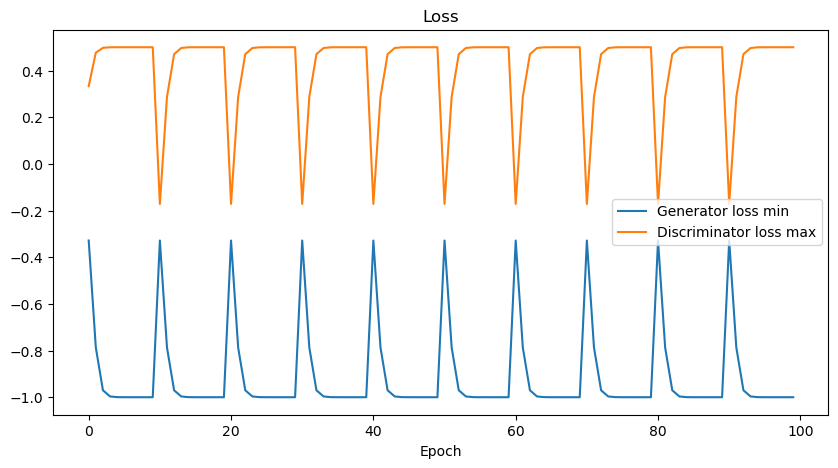

In [16]:
loss_d = [ -x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss min")
plt.plot(range(len(step_d)), loss_d, label="Discriminator loss max")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [17]:
@qml.qnode(dev, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()
@qml.qnode(dev, interface="tf")
def circuit_rs():
    real()
    return qml.state()

red_r = qml.math.reduced_dm(circuit_rs(),indices=[0])
red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
state_fidelity = qml.math.fidelity(red_r, red_g)
print(state_fidelity)

tf.Tensor(0.7500337714600706, shape=(), dtype=float64)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), sg, label="fidelity")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()